# Portfolio Weights

The sum of weights must add to 1. Instead of trying to add cash to the portfolio, try scaling up the weights.

In [83]:
portfolio_weights =[("GOOG",.3),("AAPL",.3),("FLGT",.2),("OIH",.2)]
start_date = "2020-01-1"
if abs(sum(x for _,x in portfolio_weights) -1)>1e-7:
  raise ValueError("Portfolio Weights must add to 1")

# Data Retrievers

In [141]:
import requests
import logging
from io import StringIO
import pandas as pd
import datetime as dt
def yahoofin_ts(ticker):
  url = "https://query1.finance.yahoo.com/v7/finance/download/" + ticker+"?period1=1281181669&period2=1612804069&interval=1d&events=history&includeAdjustedClose=true"
  try: 
    r = requests.get(url)
  except Excepion as e:
    logging.error("Could not get data for ticker:%s" %ticker)
  tdf= pd.read_csv(StringIO(r.text))
  # Assumes Date column is present
  tdf["Date"] = tdf.Date.apply(lambda x: dt.datetime.strptime(x,"%Y-%m-%d").date())
  return tdf

alldatadfs = []
for entry,weight in portfolio_weights:
  datadf = yahoofin_ts(entry).copy()
  datadf["Ticker"] = entry
  alldatadfs.append(datadf)
#preparing the big df for ease of passing around
portfolio_tickers_df = pd.concat(alldatadfs)
portfolio_tickers_df

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2010-08-09,250.187241,251.806168,249.743896,251.731445,251.731445,3758435,GOOG
1,2010-08-10,250.237045,252.055237,248.354111,250.914505,250.914505,4163548,GOOG
2,2010-08-11,247.935669,248.070175,244.832306,244.951859,244.951859,4462665,GOOG
3,2010-08-12,241.066422,246.451233,240.354095,245.086349,245.086349,4425727,GOOG
4,2010-08-13,243.586975,244.677887,242.097565,242.266922,242.266922,3883903,GOOG
...,...,...,...,...,...,...,...,...
2639,2021-02-02,168.860001,171.070007,165.320007,165.580002,165.580002,229000,OIH
2640,2021-02-03,166.490005,173.860001,166.490005,173.580002,173.580002,394900,OIH
2641,2021-02-04,175.000000,177.539993,170.649994,177.389999,177.389999,376300,OIH
2642,2021-02-05,179.699997,181.779999,176.070007,176.809998,176.809998,329200,OIH


# Plot the time-series for all portfolio constituents

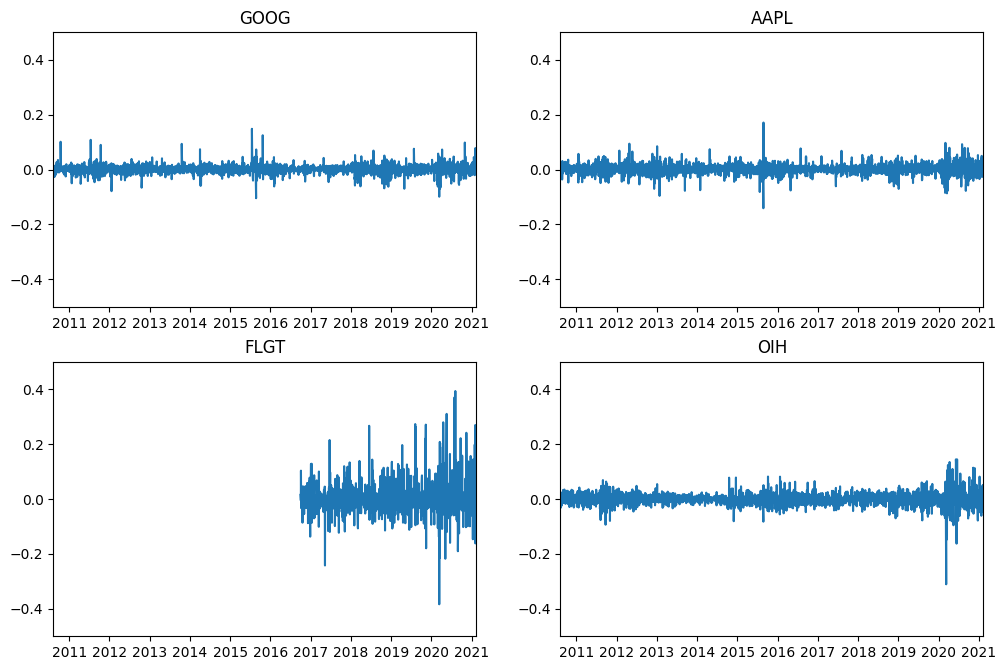

In [143]:
import matplotlib.pyplot as plt
from itertools import product
plot_open_prices = lambda x: plt.plot(x.Date,x.Open)
returns_open = lambda x : (list(x.shift(-1).Date)[0:-1], list((x.shift(-1).Open /x.Open) -1)[0:-1])

def plot_daily_returns_open (x):
  data = returns_open(x)
  matplotlib.pyplot.plot (data[0],data[1])

n = len(portfolio_weights)
nx=int(math.sqrt(n))
ny=int(n/nx) if n/nx==int(n/nx) else int(n/nx)+1

fig, axs = plt.subplots(nx, ny,figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
i = 0
# Extracting dfs back into an array
plotdfs = [ portfolio_tickers_df[portfolio_tickers_df.Ticker==ticker_entry] for ticker_entry,_ in portfolio_weights]
xlim_min  = min(min(xdf.Date) for xdf in plotdfs)
xlim_max  = max(max(xdf.Date) for xdf in plotdfs)
for x,y in product(range(0,nx),range(0,ny)):
  if i < n:
    plot_data = returns_open(plotdfs[i])
    axs[x,y].set_xlim(xlim_min,xlim_max)
    axs[x,y].set_ylim(-.5,.5)
    axs[x,y].plot(plot_data[0],plot_data[1])
    axs[x,y].set_title(list(set(plotdfs[i].Ticker))[0])
  i=i+1
